In [266]:
#Imports 

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, BasicAer, execute
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info.states import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector, plot_bloch_vector
from qiskit.aqua.components.initial_states import Custom
from qiskit.tools.visualization import plot_state_qsphere
%matplotlib inline
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from kaleidoscope.interactive import bloch_sphere

# Task 1 QCMP

### 1. 
Provide a variational (also called parametric) circuit which is able to generate the most general 1 qubit state. By most general 1 qubit state we mean that there exists a set of the parameters in the circuit such that any point in the Bloch sphere can be reached. Check that the circuit works correctly by showing that by varying randomly the parameters of your circuit you can reproduce correctly the Bloch sphere.

### Approach 

Let $\rho$ be the most general 1 qubit state. Then $\rho$ can be expressed as:

$$\lambda_{1} | \psi\rangle\langle\psi| + \lambda_{2}| \psi^{\bot}\rangle\langle\psi^{\bot}|$$

Expanded into the computational basis states $\psi$ and $\psi^{\bot}$ are given by:

$$|\psi\rangle = \cos\frac{\theta}{2}|0\rangle + e^{i\phi}\sin\frac{\theta}{2}|1\rangle$$

$$|\psi^{\bot}\rangle = \sin\frac{\theta}{2}|0\rangle + e^{i\phi}\cos\frac{\theta}{2}|1\rangle$$


The unit trace of $\rho$ has $\lambda_{1}$ + $\lambda_{2} = 1 = tr(U)$. Thus  $\lambda_{1}$, $\lambda_{2}$ can be given by an angle $\beta$ such that:
$\lambda_{1} = \cos^{2}\frac{\beta}{2}$ and $\lambda_{2} = \sin^{2}\frac{\beta}{2}$

###### Hence $\rho$ can be described by three parameters: $\theta$, $\phi$, $\beta$

Rotations used for state transformation:
$R_{y}(\theta)$, $R_{z}(\phi)$, $U(\theta, \phi)$
\
\
Where $U(\theta, \phi) = \begin{pmatrix}\cos\frac{\theta}{2} & -\sin\frac{\theta}{2}\\e^{i\phi}\sin\frac{\theta}{2} & e^{i\phi}\cos\frac{\theta}{2} \end{pmatrix}$



### Solution: 
In the following solutions, I created a circuit in which an auxilary qubit, prepared in the state: 
$\cos\frac{\beta}{2}|0\rangle + \sin\frac{\beta}{2}|1\rangle$ is used with a data qubit in the CNOT gate.

The preparation of the auxiliary qubit is handled by the $R_{y}(\beta)$, or circ.ry.(beta, aux)

##### After the CNOT gate the state of both the data and auxiliary qubit are: 
$\cos\frac{\beta}{2}|0\rangle|\psi\rangle + \sin\frac{\beta}{2}|1\rangle|\psi^{\bot}\rangle$

While this solution is valid, it requires the use of an auxiliary, or control, qubit. Thus, because the QuantumRegister must create both a data and control qubit, the Statevector of the circuit will record 2 qubits, even if the auxilary qubit is classically measured afterward. 

I have created two versions of the parametric circuit, one in which the auxiliary qubit is measured and thus 'discarded' and one in which the circuit remains unmeasured.  


<img src="files/varcircuit.png" width="600" height="300">

The picture above is of the measured circuit

In [455]:
def parametricCircuit_Measured(theta: float=None, phi: float=None, beta: float=None) -> Statevector:
    """ Parametric circuit takes parameters 𝜃, 𝜙, 𝛽 to generate the most general single qubit state
    """
    if not theta:
        theta = np.random.uniform(-1,1) * pi
    if not phi:
        phi = np.random.uniform(-1,1) * pi
    if not beta:
        beta = np.random.uniform(-1,1) * pi
        
    init_vector = [1,0] # Initial state vector.
    qreg_q = QuantumRegister(1, 'q') # Initialize data qubit
    areg_a = QuantumRegister(1, 'a') # Initialize auxiliary qubit
    creg_c = ClassicalRegister(2, 'c') # Initialize bits for record measurements
    circ = QuantumCircuit(qreg_q, areg_a, creg_c)
    circ.initialize(init_vector, [qreg_q[0]])
    circ.initialize(init_vector, [areg_a[0]])
    
    # Apply rotation R_y(𝛽) to the auxiliary qubit 
    circ.ry(beta, areg_a[0])
    
    # The aux qubit is placed through an CNOT gate with the data qubit as a target
    circ.cx(qreg_q[0], areg_a[0])
    
    # Rotation R_y(𝜃) and R_z(𝜙) to the data qubit 
    circ.ry(theta, qreg_q[0])
    # Discard the aux qubit
    circ.measure(areg_a[0], creg_c[1])
    circ.rz(phi, qreg_q[0])
    
    statevector = execute(circ, backend=BasicAer.get_backend('statevector_simulator')).result().get_statevector()
    return statevector

In [456]:
def parametricCircuit_Unmeasured(theta: float=None, phi: float=None, beta: float=None) -> Statevector:
    """ Parametric circuit takes parameters 𝜃, 𝜙, 𝛽 to generate the most general single qubit state
    """
    if not theta:
        theta = np.random.uniform(-1,1) * pi
    if not phi:
        phi = np.random.uniform(-1,1) * pi
    if not beta:
        beta =  phi = np.random.uniform(-1,1) * pi
        
    init_vector = [1,0] # Initial state vector.
    qreg_q = QuantumRegister(1, 'q') # Initialize data qubit
    areg_a = QuantumRegister(1, 'a') # Initialize aux qubit
    creg_c = ClassicalRegister(1, 'c') # Initialize bits for record measurements
    circ = QuantumCircuit(qreg_q, areg_a, creg_c)
    circ.initialize(init_vector, [qreg_q[0]])
    circ.initialize(init_vector, [areg_a[0]])
    
    # Apply rotation R_y(𝛽) to the auxiliary qubit 
    circ.ry(beta, areg_a[0])
    
    # The aux qubit is placed through an CNOT gate with the data qubit as a target
    circ.cx(qreg_q[0], areg_a[0])
    
    # Rotation R_y(𝜃) and R_z(𝜙) to the data qubit 
    circ.ry(theta, qreg_q[0])
    
    return Statevector.from_instruction(circ)

In [447]:
result = parametricCircuit_Measured(pi/2, pi/2, pi/2)
result

array([0.00000000e+00+0.j        , 0.00000000e+00+0.j        ,
       7.07106781e-01+0.j        , 4.32978028e-17+0.70710678j])

### Using Qsphere from IBM Quantum Experience we can see the state of a system by associating each computational basis state with a point on the surface of a sphere. The computational basis states can be said to span the vector space of the Bloch Sphere

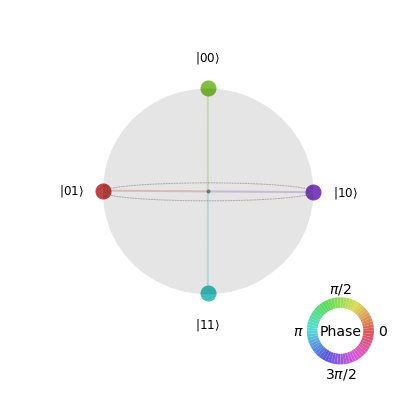

In [710]:
# circuit initial state vector. All states in equal superposition
init_vector = [1,0]
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(1, 'c')
circ = QuantumCircuit(qreg_q, creg_c)
circ.initialize(init_vector, [qreg_q[0]])
circ.initialize(init_vector, [qreg_q[1]])

# Appy rotation R_y(𝛽) to the auxiliary qubit 
circ.ry(pi/2, qreg_q[1])

# The aux qubit is placed through an CNOT gate with the data qubit as a target
circ.cx(qreg_q[0], qreg_q[1])

# Rotation R_y(𝜃) and R_z(𝜙) to the data qubit 
circ.ry(pi/2, qreg_q[0])
# Discard the aux qubit
circ.measure(qreg_q[1], creg_c[0])
circ.rz(pi/2, qreg_q[0])

#Added 
circ.h(qreg_q[0])
circ.h(qreg_q[1])
#circ.draw(output='mpl')
statevector = execute(circ, backend=Aer.get_backend('statevector_simulator')).result().get_statevector()
plot_state_qsphere(statevector)

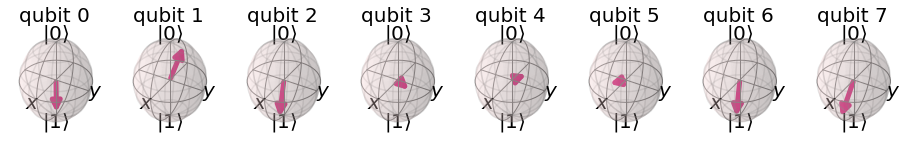

In [692]:
# Vectorstates Spanning the volume of the Bloch Sphere with multivector

q_state = parametricCircuit_Unmeasured()
for _ in range(3):
    q_state = q_state.tensor(parametricCircuit_Unmeasured())
plot_bloch_multivector(q_state)

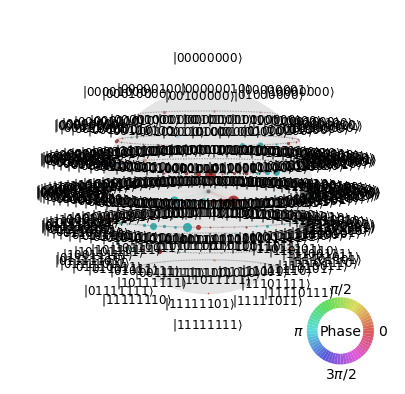

In [693]:
# Vectorstates Spanning the volume of the Bloch Sphere with qSphere

q_state = parametricCircuit_Unmeasured()
for _ in range(3):
    q_state = q_state.tensor(parametricCircuit_Unmeasured())
plot_state_qsphere(q_state)

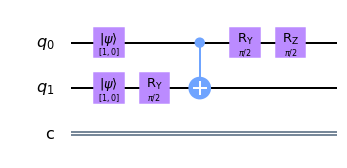

In [713]:
# Just for display an trouble shooting

# circuit initial state vector. All states in equal superposition
init_vector = [1,0]
qreg_q = QuantumRegister(2, 'q')
creg_c = ClassicalRegister(1, 'c')
circ = QuantumCircuit(qreg_q, creg_c)
circ.initialize(init_vector, [qreg_q[0]])
circ.initialize(init_vector, [qreg_q[1]])

# Superposition of states for the data qubit, q[0] and auxcillary qubit, q[1]
#circ.h(qreg_q[0])
#circ.h(qreg_q[1])

# Appy rotation R_y(𝛽) to the auxiliary qubit 
circ.ry(pi/2, qreg_q[1])

# The aux qubit is placed through an CNOT gate with the data qubit as a target
circ.cx(qreg_q[0], qreg_q[1])

# Rotation R_y(𝜃) and R_z(𝜙) to the data qubit 
circ.ry(pi/2, qreg_q[0])
# Discard the aux qubit
#circ.measure(qreg_q[1], creg_c[0])
circ.rz(pi/2, qreg_q[0])

#circ.h(qreg_q[0])
#circ.h(qreg_q[1])
circ.draw(output='mpl')
#statevector = execute(circ, backend=Aer.get_backend('statevector_simulator')).result().get_statevector()
#plot_state_qsphere(statevector)

##### However, in part 2. I find that that no matter which backends I use - be it the statevector_simulator or qasm_simulator - to manage the Statevector object of the parametric circuit, when I initialize the generalized Statevector produced by the either circuit, the Swap Test circuit initialization always sees a two qubit system. 

### Part 2. 
Use the circuit built in step 1) and, using the SWAP test, find the best choice of your parameters to reproduce a randomly generated quantum state made with 1 qubit.

In [706]:
def Swap_Test1(state_1: Statevector, state_2: Statevector, shots=1024) -> float:
    
    qreg_q = QuantumRegister(3, 'q') # Initialize qubits
    creg_c = ClassicalRegister(1, 'c') # Initialize bits for record measurements
    circ = QuantumCircuit(qreg_q, creg_c)
    # Initialization 
    circ.initialize(state_1, (qreg_q[0], qreg_q[1]))
    circ.initialize(state_2, (qreg_q[2]))

    #Swap test
    circ.h(qreg_q[0])
    circ.cswap(qreg_q[0], qreg_q[1], qreg_q[2])
    circ.h(qreg_q[0])

    circ.measure(qreg_q[0], creg_c[0])

    # Run with local simulator
    backend = Aer.get_backend('qasm_simulator')
    results = execute(circ, backend=backend, shots=shots).result()
    answer = results.get_counts()
    return answer['0'] / shots
    

In [707]:
# When measuring the auxiliary qubit value in parametricCircuit_1 we get a signle qubit statevector

state_from_measuredAuxCircuit = parametricCircuit_Measured()
state_from_measuredAuxCircuit

array([0.        +0.j        , 0.        +0.j        ,
       0.02414674+0.j        , 0.99306952-0.11502113j])

In [708]:
Swap_Test1(state_from_measuredAuxCircuit, [1,0])

0.4736328125

In [402]:
def Swap_Test2(state_1: Statevector, state_2: Statevector, shots=1024) -> float:
    
    qreg_q = QuantumRegister(3, 'q') # Initialize qubits
    creg_c = ClassicalRegister(1, 'c') # Initialize bits for record measurements
    circ = QuantumCircuit(qreg_q, creg_c)
     # Initialization 
    circ.initialize(state_1.data, (qreg_q[0], qreg_q[1]))
    circ.initialize(state_2.data, (qreg_q[2]))

    #Swap test
    circ.h(qreg_q[0])
    circ.cswap(qreg_q[0], qreg_q[1], qreg_q[2])
    circ.h(qreg_q[0])

    circ.measure(qreg_q[0], creg_c[0])

    # Run with local simulator
    backend = Aer.get_backend('qasm_simulator')
    results = execute(circ, backend=backend, shots=shots).result()
    answer = results.get_counts()
    return answer['0'] / shots

In [470]:
# When measuring the statevector from the circuit with unmeasured aux qubit we expect num_qubits
# to be two because the control is still present
state_from_unmeasuredAux = parametricCircuit_Unmeasured()
state_from_unmeasuredAux.data

array([ 0.21396284+0.j, -0.15648285+0.j,  0.77829069+0.j, -0.569207  +0.j])

In [475]:
Swap_Test2(state_from_unmeasuredAux, Statevector([1,0]))

0.5234375

The polar $\theta$ and Azimuth $\phi$ angles that maximaze the probability of generation a basis of the most generalized states are $\theta = \frac{\pi}{2}$ and $\phi = \frac{\pi}{2}$ because they produce a statespace that spans the entire bloch sphere. 

### Part 3. 

Suppose you are given with a random state, made by N qubits, for which you only know that it is a product state and each of the qubits are in the state | 0 > or | 1>. Perform a qubit by qubit SWAP test to reconstruct the state. This part of the problem can be solved via a simple grid search.

Fortunately I have read the recent paper published on using the SWAP Gate to determine entaglement conditions; composite sites from product states. I wish had more time to play with this question!

In [671]:
def product_states(num_qbits: int) -> Statevector:
    # Generate initial product states to test
    basis = ([1, 0], [0, 1])
    p_states = Statevector(basis[np.random.randint(0, 2)])
    for _ in range(num_qbits - 1):
        p_states = p_states.tensor(Statevector(basis[np.random.randint(0, 2)]))
    return p_states

In [714]:
def reconstruct_product_state(given_state: Statevector, shots=1024) -> Statevector:
    """reconstruct_product_state: from an input product state (|0> and |1>) perform Swap Test to sort qubits to initial state
    """
    # Declare variables, initialize circuit and classical register 
    ket_0 = [1, 0]
    ket_1 = [0, 1]
    qreg_q = QuantumRegister(given_state.num_qubits + 2, 'q')
    creg_c = ClassicalRegister(1, 'c')
    circ = QuantumCircuit(qreg_q, creg_c)
    circ.initialize(given_state.data, list(range(given_state.num_qubits)))
    mqbitIndex = given_state.num_qubits
    compareIndex = given_state.num_qubits + 1
    reconstructed_state: Statevector = None
    # iterate over qubits 
    for i in range(given_state.num_qubits):
        # Swap Test & get data 
        circ.h(qreg_q[mqbitIndex])
        circ.cswap(qreg_q[mqbitIndex], qreg_q[i], qreg_q[compareIndex])
        circ.h(qreg_q[mqbitIndex])
        circ.measure(qreg_q[mqbitIndex], creg_c[0])
        results = execute(circ, backend=backend, shots=shots).result()
        answer = results.get_counts()
        # Check qubit states
        if answer['0'] == shots: 
            if not reconstructed_state:
                reconstructed_state = Statevector([1, 0])
            else:
                reconstructed_state = Statevector([1, 0]).tensor(reconstructed_state)
        # at |1>      
        else:
            if not reconstructed_state:
                reconstructed_state = Statevector([0, 1])
            else:
                reconstructed_state = Statevector([0, 1]).tensor(reconstructed_state)
        circ.initialize([1, 0], mqbitIndex)
        circ.initialize([1, 0], compareIndex)
        
    return reconstructed_state

In [683]:
product_state = product_states(num_qbits=5)

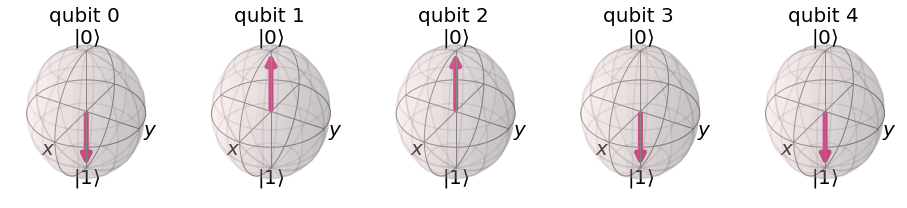

In [684]:
# Original Product State
plot_bloch_multivector(product_state)

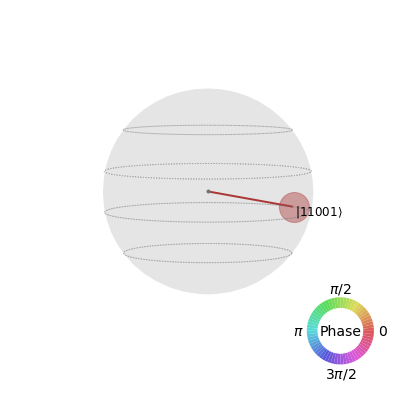

In [685]:
# Original Product State on qsphere
plot_state_qsphere(product_state)

In [686]:
reconstructed_state = reconstruct_product_state(given_state, shots=1024)

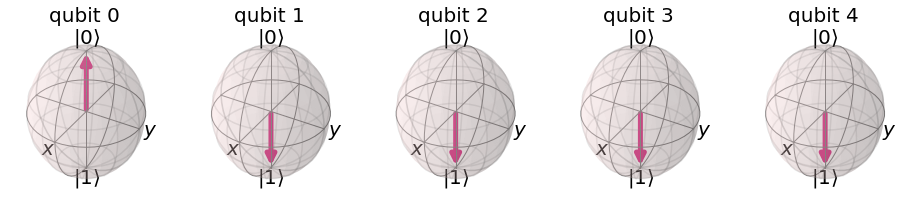

In [687]:
# Final state reconstruction
plot_bloch_multivector(reconstructed_state)

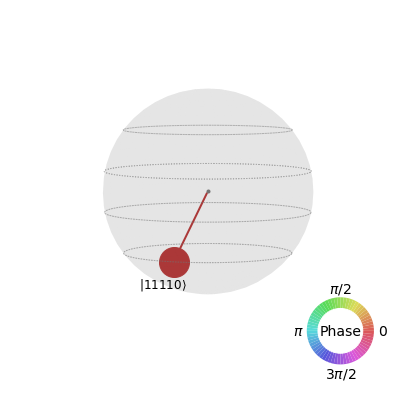

In [681]:
# Final state reconstruction q-sphere
plot_state_qsphere(reconstructed_state)